# ML with SAS Viya and the SWAT Package

This demonstration shows open source integration with SAS Viya from the R API.

# Data

| Name      | Model Role | Measurement Level | Description                                                            |
|:----------|:-----------|:------------------|:-----------------------------------------------------------------------|
| BAD       | Target     | Binary            | 1 = applicant defaulted on loan or delinquent, 0 = applicant paid loan |
| CLAGE     | Input      | Interval          | Age of oldest credit line in months                                    |
| CLNO      | Input      | Interval          | Number of credit lines                                                 |
| DEBTINC   | Input      | Interval          | Debt-to-income ratio                                                   |
| DELINQ    | Input      | Interval          | Number of delinquent credit lines                                      |
| DEROG     | Input      | Interval          | Number of derogatory reports                                           |
| JOB       | Input      | Nominal           | Occupational categories                                                |
| LOAN      | Input      | Interval          | Amount of loan request                                                 |
| MORTDUE   | Input      | Interval          | Amount due on existing mortgage                                        |
| NINQ      | Input      | Interval          | Number of recent credit inquiries                                      |
| REASON    | Input      | Binary            | DebtCon = debt consolidation, HomeImp = home improvement               |
| VALUE     | Input      | Interval          | Value of current property                                              |
| YOJ       | Input      | Interval          | Years at present job                                                   |

# Load Packages

In [1]:
library(swat)
library(sasctl)
library(jsonlite)
library(zip)

SWAT 1.8.2


Attaching package: 'zip'


The following objects are masked from 'package:utils':

    unzip, zip




# Get Key Variables

In [2]:
df = read.csv(paste0(dirname(getwd()),"/password_r.txt"), header=TRUE, stringsAsFactors=FALSE)

# Connect to CAS

In [3]:
conn = CAS(hostname=df$hostname, port=df$port, username=df$username, password=df$password, protocol=df$protocol)

NOTE: Connecting to CAS and generating CAS action functions for loaded
      action sets...

NOTE: To generate the functions with signatures (for tab completion), set 
      options(cas.gen.function.sig=TRUE).



# Load Data

In [4]:
df_cas = cas.read.csv(conn, file=paste0(dirname(getwd()),"/Data/hmeq.csv"), casOut=list(name="hmeq", replace=TRUE))

NOTE: Cloud Analytic Services made the uploaded file available as table HMEQ in caslib CASUSER(jobake).



In [5]:
cas.table.tableInfo(conn)

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,⋯,Repeated,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,⋯,<int>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>
1,HMEQ,5960,13,0,utf-8,2023-06-09T19:25:20+00:00,2023-06-09T19:25:20+00:00,2023-06-09T19:25:20+00:00,UTF8,2001957920,⋯,0,0,0,,,0,jobake,,2023-06-09T19:25:20+00:00,2001957920


# View Data

[SWAT Functionality](https://developer.sas.com/apis/swat/python/1.0.0/api.html)

In [6]:
head(df_cas)

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1100,25860,39025,HomeImp,Other,10.5,0,0,94.36667,1,9,NaN
2,1,1300,70053,68400,HomeImp,Other,7.0,0,2,121.83333,0,14,NaN
3,1,1500,13500,16700,HomeImp,Other,4.0,0,0,149.46667,1,10,NaN
4,1,1500,NaN,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0,1700,97800,112000,HomeImp,Office,3.0,0,0,93.33333,0,14,NaN
6,1,1700,30548,40320,HomeImp,Other,9.0,0,0,101.46600,1,8,37.11361


In [7]:
colMeans(df_cas[c("BAD","LOAN","MORTDUE")])

BAD         LOAN      MORTDUE 
1.994966e-01 1.860797e+04 7.376082e+04

In [8]:
summary(df_cas)

      BAD              LOAN          MORTDUE           VALUE       
 Min.   :0.0000   Min.   : 1100   Min.   :  2063   Min.   :  8000  
 1st Qu.:0.0000   1st Qu.:11100   1st Qu.: 46268   1st Qu.: 66069  
 Median :0.0000   Median :16300   Median : 65019   Median : 89236  
 Mean   :0.1995   Mean   :18608   Mean   : 73761   Mean   :101776  
 3rd Qu.:0.0000   3rd Qu.:23300   3rd Qu.: 91491   3rd Qu.:119832  
 Max.   :1.0000   Max.   :89900   Max.   :399550   Max.   :855909  
                                  NA's   :   518   NA's   :   112  
     REASON          JOB            YOJ              DEROG         
 DebtCon:3928   Mgr    : 767   Min.   :  0.000   Min.   :  0.0000  
 HomeImp:1780   Office : 948   1st Qu.:  3.000   1st Qu.:  0.0000  
 NA's   : 252   Other  :2388   Median :  7.000   Median :  0.0000  
                ProfExe:1276   Mean   :  8.922   Mean   :  0.2546  
                Sales  : 109   3rd Qu.: 13.000   3rd Qu.:  0.0000  
                Self   : 193   Max.   : 41.000  

[CAS Actions Documentation](https://go.documentation.sas.com/doc/en/pgmsascdc/v_033/allprodsactions/actionSetsByName.htm)

In [9]:
loadActionSet(conn, 'simple')

NOTE: Added action set 'simple'.

NOTE: Information for action set 'simple':

NOTE:    simple

NOTE:       mdSummary - Calculates multidimensional summaries of numeric variables

NOTE:       numRows - Shows the number of rows in a Cloud Analytic Services table

NOTE:       summary - Generates descriptive statistics of numeric variables such as the sample mean, sample variance, sample size, sum of squares, and so on

NOTE:       correlation - Computes Pearson product-moment correlations.

NOTE:       regression - Performs a linear regression up to 3rd-order polynomials

NOTE:       crossTab - Performs one-way or two-way tabulations

NOTE:       distinct - Computes the distinct number of values of the variables in the variable list

NOTE:       topK - Returns the top-K and bottom-K distinct values of each variable included in the variable list based on a user-specified ranking order

NOTE:       groupBy - Builds BY groups in terms of the variable value combinations given the variables in

In [10]:
cas.simple.freq(conn,
    table = "hmeq",
    inputs = c("BAD","JOB","REASON")
)

,Column,NumVar,CharVar,FmtVar,Level,Frequency
,<chr>,<dbl>,<chr>,<chr>,<dbl>,<int>
1,BAD,0,,0,1,4771
2,BAD,1,,1,2,1189
3,JOB,NaN,,,1,279
4,JOB,NaN,Mgr,Mgr,2,767
5,JOB,NaN,Office,Office,3,948
6,JOB,NaN,Other,Other,4,2388
7,JOB,NaN,ProfExe,ProfExe,5,1276
8,JOB,NaN,Sales,Sales,6,109
9,JOB,NaN,Self,Self,7,193


In [11]:
loadActionSet(conn, 'sampling')

NOTE: Added action set 'sampling'.

NOTE: Information for action set 'sampling':

NOTE:    sampling

NOTE:       srs -  Samples a proportion of data from the input table or partitions the data into no more than three portions

NOTE:       stratified - Samples a proportion of data or partitions the data into no more than three portions within each stratum

NOTE:       oversample - Samples a user-specified proportion of data from the event level and adjusts the ratio between rare events and non-rare events to a user-specified ratio

NOTE:       kfold - K-fold partitioning.



In [12]:
cas.sampling.srs(conn,
    table   = "hmeq",
    samppct = 50,
    seed = 12345,
    partind = FALSE,
    output  = list(casOut = list(name = 'mysam', replace = T), copyVars = 'ALL')
)

mysam = defCasTable(conn, table='mysam')
df_plot = to.casDataFrame(mysam)

NOTE: Simple Random Sampling is in effect.

NOTE: Using SEED=12345 for sampling.



$OutputCasTables
           casLib  Name Label Rows Columns
1 CASUSER(jobake) mysam       2980      13

$SRSFreq
  NObs NSamp
1 5960  2980

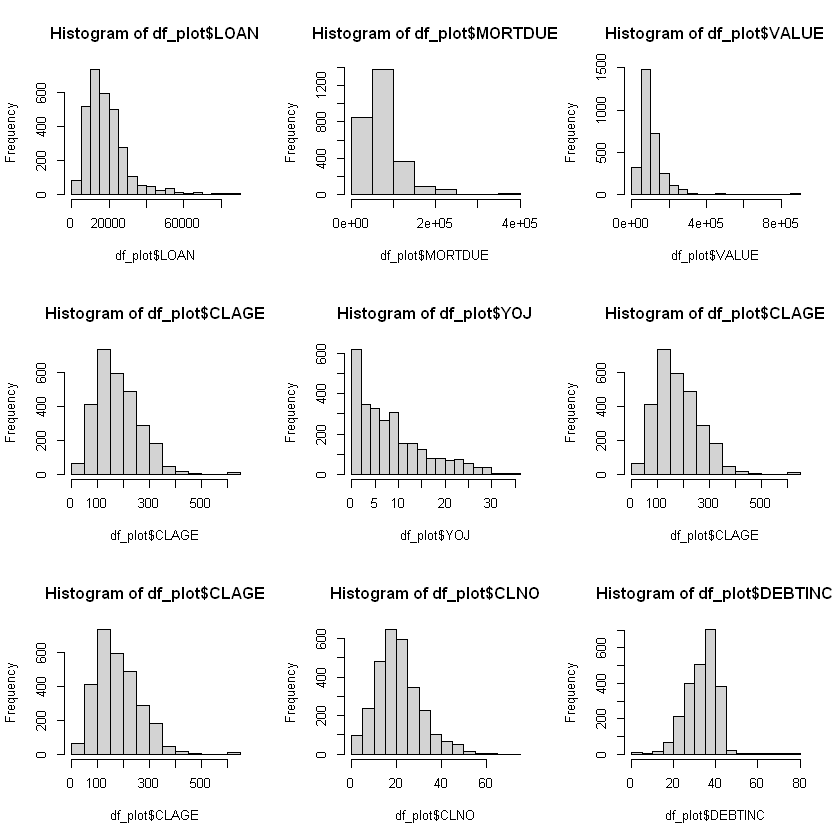

In [13]:
hist_vars = c("LOAN","MORTDUE","VALUE","CLAGE","YOJ","CLAGE","CLAGE","CLNO","DEBTINC")
par(mfrow = c(3, 3))
for(i in 1:9){
    eval(parse(text=paste0("hist(df_plot$",hist_vars[i],")")))
}
par(mfrow = c(1, 1))

# Cloud vs Local Data

In [14]:
class(df_cas)

[1] "CASTable"
attr(,"package")
[1] "swat"

In [15]:
class(df_plot)

[1] "casDataFrame"
attr(,"package")
[1] "swat"

# Impute Missing Values

In [16]:
cas.simple.distinct(df_cas)$Distinct[,c('Column', 'NMiss')]

,Column,NMiss
,<chr>,<int>
1,BAD,0
2,LOAN,0
3,MORTDUE,518
4,VALUE,112
5,REASON,252
6,JOB,279
7,YOJ,515
8,DEROG,708
9,DELINQ,580


In [17]:
cas.dataPreprocess.impute(conn,
    table = "hmeq",
    methodContinuous = 'MEDIAN',
    methodNominal    = 'MODE',
    inputs           = colnames(df_cas)[-1],
    copyAllVars      = TRUE,
    casOut           = list(name = "hmeq", replace = TRUE),
    code = list(casOut = list(name = "score_code_impute", replace = TRUE))
)

,Variable,ImputeTech,ResultVar,N,NMiss,ImputedValueContinuous,ImputedValueNominal
,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>
1,LOAN,Median,IMP_LOAN,5960,0,16300.00000,
2,MORTDUE,Median,IMP_MORTDUE,5442,518,65019.00000,
3,VALUE,Median,IMP_VALUE,5848,112,89235.50000,
4,REASON,Mode,IMP_REASON,5708,252,NaN,DebtCon
5,JOB,Mode,IMP_JOB,5681,279,NaN,Other
6,YOJ,Median,IMP_YOJ,5445,515,7.00000,
7,DEROG,Median,IMP_DEROG,5252,708,0.00000,
8,DELINQ,Median,IMP_DELINQ,5380,580,0.00000,
9,CLAGE,Median,IMP_CLAGE,5652,308,173.46667,


# Get Variables

In [18]:
colinfo = cas.table.columnInfo(conn, table="hmeq")$ColumnInfo 
colinfo

# Target variable is the first variable 
target = colinfo$Column[1] 

# Get all variables 
inputs = colinfo$Column[-1] 
nominals = c(target, subset(colinfo, Type == 'varchar')$Column) 

# Get only imputed variables 
inputs = grep('IMP_', inputs, value = T) 
nominals = c(target, grep('IMP_', nominals, value = T)) 

# Print 
target 
inputs 
nominals

,Column,Label,ID,Type,RawLength,FormattedLength,Format,NFL,NFD
,<chr>,<chr>,<dbl>,<chr>,<int>,<int>,<chr>,<int>,<int>
1,BAD,,1,double,8,12,,0,0
2,LOAN,,2,double,8,12,,0,0
3,MORTDUE,,3,double,8,12,,0,0
4,VALUE,,4,double,8,12,,0,0
5,REASON,,5,varchar,7,7,,0,0
6,JOB,,6,varchar,7,7,,0,0
7,YOJ,,7,double,8,12,,0,0
8,DEROG,,8,double,8,12,,0,0
9,DELINQ,,9,double,8,12,,0,0


[1] "BAD"

[1] "IMP_CLAGE"   "IMP_CLNO"    "IMP_DEBTINC" "IMP_DELINQ"  "IMP_DEROG"  
 [6] "IMP_LOAN"    "IMP_MORTDUE" "IMP_NINQ"    "IMP_VALUE"   "IMP_YOJ"    
[11] "IMP_JOB"     "IMP_REASON"

[1] "BAD"        "IMP_JOB"    "IMP_REASON"

# Partition Data

In [19]:
cas.sampling.srs(conn,
    table   = "hmeq",
    samppct = 70,
    samppct2 = 20,
    seed = 919,
    partind = TRUE,
    output  = list(casOut = list(name = "hmeq", replace = TRUE),  copyVars = 'ALL')
)

NOTE: Simple Random Sampling is in effect.

NOTE: Using SEED=919 for sampling.



$OutputCasTables
           casLib Name Label Rows Columns
1 CASUSER(jobake) hmeq       5960      26

$SRSFreq
  NObs NSamp1 NSamp2
1 5960   4172   1192

# Dimension Reduction

In [20]:
loadActionSet(conn, 'varReduce')

NOTE: Added action set 'varReduce'.

NOTE: Information for action set 'varReduce':

NOTE:    varReduce

NOTE:       unsuper - Provides an action for performing unsupervised dimension reduction

NOTE:       super - Provides an action for performing supervised dimension reduction



In [21]:
varReduce_obj = cas.varReduce.unsuper(conn,
    table = "hmeq",
    inputs = inputs,
    nominals = nominals[-1],
    varexp = 0.95
)

In [22]:
varReduce_inputs = varReduce_obj$'SelectedEffects'$'Variable'
varReduce_inputs

[1] "IMP_REASON"  "IMP_VALUE"   "IMP_JOB"     "IMP_DEROG"   "IMP_YOJ"    
 [6] "IMP_DEBTINC" "IMP_DELINQ"  "IMP_CLAGE"   "IMP_NINQ"    "IMP_LOAN"   
[11] "IMP_CLNO"

In [23]:
print(paste("The variable", setdiff(inputs,varReduce_inputs), "was removed from the input list."))

[1] "The variable IMP_MORTDUE was removed from the input list."


# Logistic Regression

In [24]:
loadActionSet(conn, 'regression')

NOTE: Added action set 'regression'.

NOTE: Information for action set 'regression':

NOTE:    regression

NOTE:       glm - Fits linear regression models using the method of least squares

NOTE:       genmod - Fits generalized linear regression models

NOTE:       logistic - Fits logistic regression models

NOTE:       logisticType3 - computes Type 3 or Joint tests that all parameters for an effect are zero

NOTE:       logisticCode - writes SAS DATA step code for computing predicted values of the fitted model

NOTE:       genmodScore - creates a table on the server that contains results from scoring observations by using a fitted model

NOTE:       logisticScore - creates a table on the server that contains results from scoring observations by using a fitted model

NOTE:       glmScore - creates a table on the server that contains results from scoring observations by using a fitted model

NOTE:       logisticAssociation - computes indices of rank correlation between predicted probabi

In [25]:
lr_model = cas.regression.logistic(conn,
    table    = list(name = "hmeq", where = '_PartInd_ = 1'),
    classVars = nominals[-1],
    model = list(depvar=target, effects=varReduce_inputs, dist='binomial', link='logit'),
    store    = list(name='lr_model',replace=TRUE)
)

NOTE: Convergence criterion (GCONV=1E-8) satisfied.

NOTE: 450993 bytes were written to the table "lr_model" in the caslib "CASUSER(jobake)".



In [26]:
lr_score = cas.regression.logisticScore(conn,
    table    = list(name = "hmeq", where = '_PartInd_ = 2'),
    restore = "lr_model",
    casout = list(name="lr_scored", replace=TRUE),
    copyVars = target
)

In [27]:
lr_assess = cas.percentile.assess(conn,
   table = 'lr_scored',
   inputs = "_PRED_",
   casout = list(name="lr_assess", replace=TRUE),
   response = target,
   event = "1"
)

cas.table.fetch(conn, table="lr_assess", to=3)
cas.table.fetch(conn, table="lr_assess_ROC", to=3)

,_Index_,_Column_,_Event_,_Depth_,_Value_,_NObs_,_NEvents_,_NEventsBest_,_Resp_,_RespBest_,⋯,_CumResp_,_CumRespBest_,_CumLift_,_CumLiftBest_,_PctResp_,_PctRespBest_,_CumPctResp_,_CumPctRespBest_,_Gain_,_GainBest_
,<dbl>,<chr>,<chr>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>
1,1,_PRED_,1,5,0.6850714,60,46,60,19.40928,25.31646,⋯,19.40928,25.31646,3.881857,5.063291,76.66667,100,76.66667,100,2.881857,4.063291
2,2,_PRED_,1,10,0.4626369,60,34,60,14.34599,25.31646,⋯,33.75527,50.63291,3.375527,5.063291,56.66667,100,66.66667,100,2.375527,4.063291
3,3,_PRED_,1,15,0.3512977,60,22,60,9.28270,25.31646,⋯,43.03797,75.94937,2.869198,5.063291,36.66667,100,56.66667,100,1.869198,4.063291


,_Index_,_Column_,_Event_,_Cutoff_,_TP_,_FP_,_FN_,_TN_,_Sensitivity_,_Specificity_,⋯,_FPR_,_ACC_,_FDR_,_F1_,_C_,_GINI_,_GAMMA_,_TAU_,_MiscEvent_,_FNR_
,<dbl>,<chr>,<chr>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,_PRED_,1,0.00,237,955,0,0,1.0000000,0.00000000,⋯,1.0000000,0.1988255,0.8011745,0.3317005,0.7914529,0.5829059,0.5924895,0.1858626,0.8011745,0.000000000
2,2,_PRED_,1,0.01,237,944,0,11,1.0000000,0.01151832,⋯,0.9884817,0.2080537,0.7993226,0.3342736,0.7914529,0.5829059,0.5924895,0.1858626,0.7919463,0.000000000
3,3,_PRED_,1,0.02,235,927,2,28,0.9915612,0.02931937,⋯,0.9706806,0.2206376,0.7977625,0.3359543,0.7914529,0.5829059,0.5924895,0.1858626,0.7793624,0.008438819


In [28]:
lr_assess_ROC = defCasTable(conn, tablename = "lr_assess_ROC")
lr_assess_ROC = to.casDataFrame(lr_assess_ROC)
cutoff_index = round(lr_assess_ROC[,"_Cutoff_"],2)==0.5
lr_assess_ROC = lr_assess_ROC[cutoff_index,]
lr_metrics_cas = data.frame("Model"="Logistic Regression CAS", "Misclassification"=1-lr_assess_ROC[1,"_ACC_"], "Area_Under_Curve"=lr_assess_ROC[1,"_C_"])
lr_metrics_cas

Model,Misclassification,Area_Under_Curve
<chr>,<dbl>,<dbl>
Logistic Regression CAS,0.1619128,0.7914529


# Decision Tree

In [29]:
loadActionSet(conn, 'decisionTree')

NOTE: Added action set 'decisionTree'.

NOTE: Information for action set 'decisionTree':

NOTE:    decisionTree

NOTE:       dtreeTrain - Trains a decision tree

NOTE:       dtreeScore - Scores a table using a decision tree model

NOTE:       dtreeSplit - Splits decision tree nodes

NOTE:       dtreePrune - Prune a decision tree

NOTE:       dtreeMerge - Merges decision tree nodes

NOTE:       dtreeCode - Generates DATA step scoring code from a decision tree model

NOTE:       forestTrain - Trains a forest. This action requires a SAS Visual Data Mining and Machine Learning license

NOTE:       forestScore - Scores a table using a forest model

NOTE:       forestCode - Generates DATA step scoring code from a forest model

NOTE:       gbtreeTrain - Trains a gradient boosting tree. This action requires a SAS Visual Data Mining and Machine Learning license

NOTE:       gbtreeScore - Scores a table using a gradient boosting tree model

NOTE:       gbtreeCode - Generates DATA step scoring co

In [30]:
dt_model = cas.decisionTree.dtreeTrain(conn,
    table    = list(name = "hmeq", where = '_PartInd_ = 1'),
    target   = target, 
    inputs   = varReduce_inputs, 
    nominals = nominals,
    casOut   = list(name = 'dt_model', replace = TRUE)
)

dt_score = cas.decisionTree.dtreeScore(conn,
    table    = list(name = "hmeq", where = '_PartInd_ = 2'),
    model = "dt_model",
    casout = list(name="dt_scored", replace=TRUE),
    copyVars = target,
    encodename = TRUE,
    assessonerow = TRUE
)

dt_assess = cas.percentile.assess(conn,
   table = "dt_scored",
   inputs = "P_BAD1",
   casout = list(name="dt_assess",replace=TRUE),
   response = target,
   event = "1"
)

dt_assess_ROC = defCasTable(conn, tablename = "dt_assess_ROC")
dt_assess_ROC = to.casDataFrame(dt_assess_ROC)
cutoff_index = round(dt_assess_ROC[,"_Cutoff_"],2)==0.5
dt_assess_ROC = dt_assess_ROC[cutoff_index,]
dt_metrics_cas = data.frame("Model"="Decision Tree CAS", "Misclassification"=1-dt_assess_ROC[1,"_ACC_"], "Area_Under_Curve"=dt_assess_ROC[1,"_C_"])
dt_metrics_cas

Model,Misclassification,Area_Under_Curve
<chr>,<dbl>,<dbl>
Decision Tree CAS,0.1694631,0.6698522


# Random Forest

In [31]:
rf_model = cas.decisionTree.forestTrain(conn,
    table    = list(name = "hmeq", where = '_PartInd_ = 1'),
    target   = target, 
    inputs   = varReduce_inputs, 
    nominals = nominals,
    casOut   = list(name = 'rf_model', replace = TRUE)
)

rf_score = cas.decisionTree.forestScore(conn,
    table    = list(name = "hmeq", where = '_PartInd_ = 2'),
    model = "rf_model",
    casout = list(name="rf_scored", replace=TRUE),
    copyVars = target,
    encodename = TRUE,
    assessonerow = TRUE
)

rf_assess = cas.percentile.assess(conn,
   table = "rf_scored",
   inputs = "P_BAD1",
   casout = list(name="rf_assess",replace=TRUE),
   response = target,
   event = "1"
)

rf_assess_ROC = defCasTable(conn, tablename = "rf_assess_ROC")
rf_assess_ROC = to.casDataFrame(rf_assess_ROC)
cutoff_index = round(rf_assess_ROC[,"_Cutoff_"],2)==0.5
rf_assess_ROC = rf_assess_ROC[cutoff_index,]
rf_metrics_cas = data.frame("Model"="Random Forest CAS", "Misclassification"=1-rf_assess_ROC[1,"_ACC_"], "Area_Under_Curve"=rf_assess_ROC[1,"_C_"])
rf_metrics_cas

Model,Misclassification,Area_Under_Curve
<chr>,<dbl>,<dbl>
Random Forest CAS,0.1610738,0.8601343


# Gradient Boosting

In [32]:
gb_model = cas.decisionTree.gbtreeTrain(conn,
    table    = list(name = "hmeq", where = '_PartInd_ = 1'),
    target   = target, 
    inputs   = varReduce_inputs, 
    nominals = nominals,
    casOut   = list(name = 'gb_model', replace = TRUE)
)

gb_score = cas.decisionTree.gbtreeScore(conn,
    table    = list(name = "hmeq", where = '_PartInd_ = 2'),
    model = "gb_model",
    casout = list(name="gb_scored", replace=TRUE),
    copyVars = target,
    encodename = TRUE,
    assessonerow = TRUE
)

gb_assess = cas.percentile.assess(conn,
   table = "gb_scored",
   inputs = "P_BAD1",
   casout = list(name="gb_assess",replace=TRUE),
   response = target,
   event = "1"
)

gb_assess_ROC = defCasTable(conn, tablename = "gb_assess_ROC")
gb_assess_ROC = to.casDataFrame(gb_assess_ROC)
cutoff_index = round(gb_assess_ROC[,"_Cutoff_"],2)==0.5
gb_assess_ROC = gb_assess_ROC[cutoff_index,]
gb_metrics_cas = data.frame("Model"="Gradient Boosting CAS", "Misclassification"=1-gb_assess_ROC[1,"_ACC_"], "Area_Under_Curve"=gb_assess_ROC[1,"_C_"])
gb_metrics_cas

Model,Misclassification,Area_Under_Curve
<chr>,<dbl>,<dbl>
Gradient Boosting CAS,0.1241611,0.9119646


# Deep Learning

In [33]:
loadActionSet(conn, 'deepLearn')

NOTE: Added action set 'deepLearn'.

NOTE: Information for action set 'deepLearn':

NOTE:    deepLearn

NOTE:       buildModel - Creates an empty Deep Learning model

NOTE:       addLayer - Adds a layer to a Deep Learning model

NOTE:       removeLayer - Removes a layer from a Deep Learning model

NOTE:       dlPrune - Prunes a layer in a Deep Learning model

NOTE:       modelInfo - Displays model information

NOTE:       dlTune - Tunes hyperparameters for Deep Learning model

NOTE:       dlTrain - Trains a Deep Learning model

NOTE:       dlScore - Scores a table using a Deep Learning model

NOTE:       dlExportModel - Exports a Deep Learning model

NOTE:       dlLabelTarget - Assigns the target label information

NOTE:       dlImportModelWeights - Imports model weights from an external source

NOTE:       dlJoin - Joins the data table and the annotation table



In [34]:
cas.deepLearn.buildModel(conn,
    model = list(name='dnn', replace=TRUE),
    type = 'dnn'
)

cas.deepLearn.addLayer(conn,
    model = 'dnn',
    layer = list(type='input', std='STD'),
    replace=TRUE,
    name = 'data'
)

cas.deepLearn.addLayer(conn,
    model = 'dnn',
    layer = list(type='fc', n=15),
    srcLayers = 'data',
    replace=TRUE,
    name = 'hl1'
)

cas.deepLearn.addLayer(conn,
    model = 'dnn',
    layer = list(type='fc', n=15),
    srcLayers = 'hl1',
    replace=TRUE,
    name = 'hl2'
)

cas.deepLearn.addLayer(conn,
    model = 'dnn',
    layer = list(type='output'),
    srcLayers = 'hl2',
    replace=TRUE,
    name = 'output'
)

cas.deepLearn.modelInfo(conn,
    modelTable = 'dnn'
)

,casLib,Name,Rows,Columns
,<chr>,<chr>,<dbl>,<dbl>
1,CASUSER(jobake),dnn,1,5


,casLib,Name,Rows,Columns
,<chr>,<chr>,<dbl>,<dbl>
1,CASUSER(jobake),dnn,11,5


,casLib,Name,Rows,Columns
,<chr>,<chr>,<dbl>,<dbl>
1,CASUSER(jobake),dnn,22,5


,casLib,Name,Rows,Columns
,<chr>,<chr>,<dbl>,<dbl>
1,CASUSER(jobake),dnn,33,5


,casLib,Name,Rows,Columns
,<chr>,<chr>,<dbl>,<dbl>
1,CASUSER(jobake),dnn,48,5


,Descr,Value
,<chr>,<chr>
1,Model Name,dnn
2,Model Type,Deep Neural Network
3,Number of Layers,4
4,Number of Input Layers,1
5,Number of Output Layers,1
6,Number of Fully Connected Layers,2


In [35]:
cas.deepLearn.dlTrain(conn,
    table = list(name = "hmeq", where = '_PartInd_ = 1'),
    target = target,
    inputs = varReduce_inputs,
    nominals = nominals,
    modelTable = 'dnn',
    modelWeights = list(name='dnn_trained_weights', replace=TRUE),
    optimizer = list(miniBatchSize=50, maxEpochs=75,  loglevel=1,
                     algorithm=list(method='adam'))
)

cas.deepLearn.dlScore(conn,
    table = list(name = "hmeq", where = '_PartInd_ = 2'),
    model = 'dnn',
    initWeights = 'dnn_trained_weights',
    copyVars = target,
    casout = list(name='dnn_scored', replace=TRUE)
)

cas.percentile.assess(conn,
   table = "dnn_scored",
   inputs = "_DL_P0_",
   casout = list(name="dnn_assess", replace=TRUE),
   response = target,
   event = "1"
)

nn_assess_ROC = defCasTable(conn, tablename = "dnn_assess_ROC")
nn_assess_ROC = to.casDataFrame(nn_assess_ROC)
cutoff_index = round(nn_assess_ROC[,"_Cutoff_"],2)==0.5
nn_assess_ROC = nn_assess_ROC[cutoff_index,]
nn_metrics_cas = data.frame("Model"="Neural Network CAS", "Misclassification"=1-nn_assess_ROC[1,"_ACC_"], "Area_Under_Curve"=nn_assess_ROC[1,"_C_"])
nn_metrics_cas

NOTE:  Synchronous mode is enabled.

NOTE:  The total number of parameters is 542.

NOTE:  The approximate memory cost is 2.00 MB.

NOTE:  The total number of workers is 3.

NOTE:  The total number of threads on each worker is 48.

NOTE:  The maximum mini-batch size per thread on each worker is 50.

NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 7200.

NOTE:  The optimization reached the maximum number of epochs.

NOTE:  The total time is       3.13 (s).



,Descr,Value
,<chr>,<chr>
1,Model Name,dnn
2,Model Type,Deep Neural Network
3,Number of Layers,4
4,Number of Input Layers,1
5,Number of Output Layers,1
6,Number of Fully Connected Layers,2
7,Number of Weight Parameters,510
8,Number of Bias Parameters,32
9,Total Number of Model Parameters,542


$OutputCasTables
           casLib       Name Rows Columns
1 CASUSER(jobake) dnn_scored 1192       6

$ScoreInfo
                        Descr        Value
1 Number of Observations Read         1192
2 Number of Observations Used         1192
3 Misclassification Error (%)     14.01007
4                  Loss Error     0.371522

,casLib,Name,Rows,Columns
,<chr>,<chr>,<dbl>,<dbl>
1,CASUSER(jobake),dnn_assess,20,21
2,CASUSER(jobake),dnn_assess_ROC,100,22


Model,Misclassification,Area_Under_Curve
<chr>,<dbl>,<dbl>
Neural Network CAS,0.1401007,0.8195396


# Hyperparameter Tuning

In [36]:
all_models_cas = rbind(lr_metrics_cas, dt_metrics_cas, rf_metrics_cas, gb_metrics_cas, nn_metrics_cas)
all_models_cas = all_models_cas[order(all_models_cas$Misclassification),]
all_models_cas

,Model,Misclassification,Area_Under_Curve
,<chr>,<dbl>,<dbl>
4,Gradient Boosting CAS,0.1241611,0.9119646
5,Neural Network CAS,0.1401007,0.8195396
3,Random Forest CAS,0.1610738,0.8601343
1,Logistic Regression CAS,0.1619128,0.7914529
2,Decision Tree CAS,0.1694631,0.6698522


In [37]:
loadActionSet(conn, 'autotune')

NOTE: Added action set 'autotune'.

NOTE: Information for action set 'autotune':

NOTE:    autotune

NOTE:       tuneSvm - Automatically adjusts support vector machine parameters to tune a model for minimum error

NOTE:       tuneForest - Automatically adjusts forest parameters to tune a model for minimum error

NOTE:       tuneDecisionTree - Automatically adjusts decision tree parameters to tune a model for minimum error

NOTE:       tuneNeuralNet - Automatically adjusts neural network parameters to tune a model for minimum error

NOTE:       tuneGradientBoostTree - Automatically adjusts gradient boosting tree parameters to tune a model for minimum error

NOTE:       tuneFactMac - Automatically adjusts factorization machine parameters to tune a model for minimum error

NOTE:       tuneBnet - Automatically adjusts Bayesian network classifier parameters to tune a model for minimum error

NOTE:       tuneTsne - Automatically adjusts t-Distributed Stochastic Neighbor Embedding algorithm p

In [38]:
gb_tune_model = cas.autotune.tuneGradientBoostTree(conn,
    trainOptions = list(
        table    = list(name = "hmeq", where = '_PartInd_ = 1'),
        target   = target, 
        inputs   = varReduce_inputs, 
        nominals = nominals,
        savestate = list(name='gb_tune_astore', replace=TRUE),
        casOut   = list(name = 'gb_tune_model', replace = TRUE) ) ,
    tunerOptions = list(seed = 802, maxEvals = 10, maxTime = 60, searchmethod='GA', objective="MCE")
)

gb_tune_model$BestConfiguration

NOTE: Autotune is started for 'Gradient Boosting Tree' model.

NOTE: Autotune option SEARCHMETHOD='GA'.

NOTE: Autotune option MAXEVALS=10.

NOTE: Autotune option MAXTIME=60 (sec.).

NOTE: Autotune option SEED=802.

NOTE: Autotune objective is 'Misclassification'.

NOTE: Early stopping is activated; 'NTREE' will not be tuned.

NOTE: Autotune number of parallel evaluations is set to 3, each using 1 worker nodes.

NOTE: Automatic early stopping is activated with STAGNATION=4;  set EARLYSTOP=false to deactivate.

         Iteration       Evals     Best Objective  Elapsed Time

                 0           1             0.1134          1.32

                 1          10             0.1086          4.13

NOTE: Data was partitioned during tuning, to tune based on validation score; the final model is trained and scored on all data.

NOTE: 6609102 bytes were written to the table "gb_tune_astore" in the caslib "CASUSER(jobake)".

NOTE: The number of trees used in the final model is 150.

NOTE

,Parameter,Name,Value
,<chr>,<chr>,<chr>
1,Evaluation,Evaluation,5
2,Number of Variables to Try,M,8
3,Learning Rate,LEARNINGRATE,0.34
4,Sampling Rate,SUBSAMPLERATE,0.5
5,Lasso,LASSO,1.11111111
6,Ridge,RIDGE,1.11111111
7,Number of Bins,NBINS,91
8,Maximum Tree Levels,MAXLEVEL,7
9,Misclassification,Objective,0.1086261981


In [39]:
gb_tune_score = cas.decisionTree.gbtreeScore(conn,
    table    = list(name = "hmeq", where = '_PartInd_ = 2'),
    model = "gb_tune_model",
    casout = list(name="gb_tune_scored", replace=TRUE),
    copyVars = target,
    encodename = TRUE,
    assessonerow = TRUE
)

gb_tune_assess = cas.percentile.assess(conn,
   table = "gb_tune_scored",
   inputs = "P_BAD1",
   casout = list(name="gb_tune_assess", replace=TRUE),
   response = target,
   event = "1"
)

gb_tune_assess_ROC = defCasTable(conn, tablename = "gb_tune_assess_ROC")
gb_tune_assess_ROC = to.casDataFrame(gb_tune_assess_ROC)
cutoff_index = round(gb_tune_assess_ROC[,"_Cutoff_"],2)==0.5
gb_tune_assess_ROC = gb_tune_assess_ROC[cutoff_index,]
gb_tune_metrics_cas = data.frame("Model"="Gradient Boosting Tuned CAS", "Misclassification"=1-gb_tune_assess_ROC[1,"_ACC_"], "Area_Under_Curve"=gb_tune_assess_ROC[1,"_C_"])

all_models_cas = rbind(lr_metrics_cas, dt_metrics_cas, rf_metrics_cas, gb_metrics_cas, nn_metrics_cas, gb_tune_metrics_cas)
all_models_cas = all_models_cas[order(all_models_cas$Misclassification),]
all_models_cas

,Model,Misclassification,Area_Under_Curve
,<chr>,<dbl>,<dbl>
6,Gradient Boosting Tuned CAS,0.08808725,0.9356109
4,Gradient Boosting CAS,0.12416107,0.9119646
5,Neural Network CAS,0.14010067,0.8195396
3,Random Forest CAS,0.16107383,0.8601343
1,Logistic Regression CAS,0.16191275,0.7914529
2,Decision Tree CAS,0.16946309,0.6698522


# Model Interpretability

In [40]:
loadActionSet(conn, 'explainModel')

NOTE: Added action set 'explainModel'.

NOTE: Information for action set 'explainModel':

NOTE:    explainModel

NOTE:       linearExplainer - Uses linear models to explain already trained models. Supports global linear surrogates as well as the local methods: LIME and KERNEL SHAP.

NOTE:       partialDependence - Computes the partial dependence of an already trained model.

NOTE:       shapleyExplainer - Computes Shapley value estimates for a query given a reference table



In [41]:
pd_obj = cas.explainModel.partialDependence(conn,
    table = "hmeq",
    modelTable = "gb_tune_astore",
    inputs = varReduce_inputs,
    nominals = nominals[-1],
    predictedTarget = "P_BAD1",
    analysisVariable = list(name="IMP_DEBTINC", nbins=50),
    outputTables     = list(names="PartialDependence", replace=TRUE)
)

head(pd_obj$PartialDependence)

NOTE: Starting the partialDependence action.

NOTE: Generating replicates.

NOTE: Finished generating replicates.

NOTE: The size of the replicates dataset is approximately 5.4488 MB. To reduce the size of the dataset, decrease the value of the NBINS, MAXLEVELS, or SAMPLESIZE parameter.

NOTE: The CAS table 'PartialDependence' in caslib 'CASUSER(jobake)' has 50 rows and 4 columns.



,Bin,IMP_DEBTINC,MeanPrediction,StdErr
,<int>,<dbl>,<dbl>,<dbl>
1,1,0.5244992,0.12449406,0.007854614
2,2,4.6630227,0.12449406,0.007854614
3,3,8.8015461,0.12449406,0.007854614
4,4,12.9400696,0.12449406,0.007854614
5,5,17.0785931,0.08748464,0.006771560
6,6,21.2171165,0.08626018,0.006743483


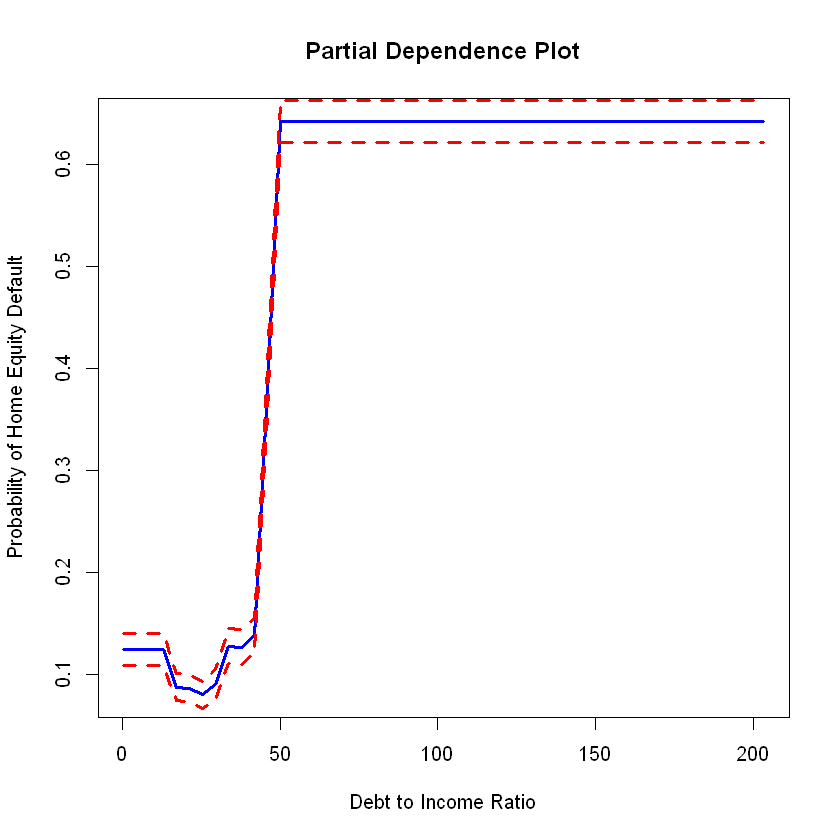

In [42]:
pd_table = defCasTable(conn, tablename = "PartialDependence")
pd_table = to.casDataFrame(pd_table)
pd_table$lb = pd_table$MeanPrediction - 2*pd_table$StdErr
pd_table$ub = pd_table$MeanPrediction + 2*pd_table$StdErr

plot(pd_table$IMP_DEBTINC,pd_table$MeanPrediction, type="l", main="Partial Dependence Plot", xlab="Debt to Income Ratio", ylab="Probability of Home Equity Default", col="blue", lwd=3)
lines(pd_table$IMP_DEBTINC,pd_table$lb, col="red", lwd=3, lty=2)
lines(pd_table$IMP_DEBTINC,pd_table$ub, col="red", lwd=3, lty=2)

# Score All Partitions

In [43]:
parts = c("Train","Valid","Test")
parts_i = c(1,2,0)

for(i in 1:length(parts)){
    print(i)
    mis = cas.decisionTree.gbtreeScore(conn, 
        table=list(name = "hmeq", where = paste0("_PartInd_=",parts_i[i])), 
        model="gb_tune_model",
        casout = list(name=paste0("gb_scored_",parts[i]), replace=TRUE),
        copyVars = c(target, "_PartInd_"),
        encodename = TRUE,
        assessonerow = TRUE)$ScoreInfo$Value[3]
    cat(paste0(parts[i]," Accuracy ="),100-round(as.numeric(mis),4),"\n")
}

[1] 1
Train Accuracy = 99.9041 
[1] 2
Valid Accuracy = 91.1913 
[1] 3
Test Accuracy = 91.443 


In [44]:
tabs = c("gb_scored_train","gb_scored_valid","gb_scored_test")
for(i in 1:length(tabs)){
    cas.table.alterTable(conn,
        name = tabs[i],
        keep = list("BAD", "P_BAD1")
    )   
}

In [45]:
df_train_scored = defCasTable(conn, tablename = "gb_scored_train")
df_train_scored = to.casDataFrame(df_train_scored)
df_valid_scored = defCasTable(conn, tablename = "gb_scored_valid")
df_valid_scored = to.casDataFrame(df_valid_scored)
df_test_scored = defCasTable(conn, tablename = "gb_scored_test")
df_test_scored = to.casDataFrame(df_test_scored)
head(df_test_scored, 3)

,BAD,P_BAD1
,<int>,<dbl>
1,1,0.9668745
2,1,0.5262484
3,1,0.9693663


# Create Metadata Directory

In [46]:
output_dir = paste0(dirname(getwd()),"/Model_Manager/Metadata")
model_name = "R_CAS_GB_Tune_Pipeline_DSSC"
data_name = "HMEQ"
zip_folder = paste0(output_dir, "/", data_name, "_", model_name)

In [47]:
if (file.exists(zip_folder)){
    unlink(zip_folder, recursive=TRUE) 
}

dir.create(zip_folder)

# Save Imputation DATA Step Score Code

In [48]:
cas.dataStep.runCode(conn, code="
    data score_code_impute (keep = DataStepSrc);
        set score_code_impute;
    run;
"
)

$InputCasTables
           casLib              Name Rows Columns
1 CASUSER(jobake) score_code_impute    1      10

$OutputCasTables
           casLib              Name Rows Columns Append Promoted
1 CASUSER(jobake) score_code_impute    1       1    NaN        N

In [49]:
score_code_impute = defCasTable(conn, tablename = "score_code_impute")
score_code_impute = to.casDataFrame(score_code_impute)
substr(score_code_impute$DataStepSrc, 1, 100)

myfile = file(paste0(zip_folder,"/scoreCode_impute.txt"))
writeLines(score_code_impute$DataStepSrc, myfile)
close(myfile)

[1] "   _ngbys_ = 1;\n   _igby_ = 0;\n   _tnn_ntrans_ = 1;\n\n   _fuzcmp_ = 2.22044604925e-10;\n\n   array _tnn"

# Save Model DATA Step Score Code

In [50]:
cas.decisionTree.gbtreeCode(conn,
    modelTable = "gb_tune_model",
    code = list(casOut = list(name = "score_code_model", replace = TRUE))
)

,casLib,Name,Rows,Columns
,<chr>,<chr>,<dbl>,<dbl>
1,CASUSER(jobake),score_code_model,1,10


In [51]:
cas.dataStep.runCode(conn, code="
    data score_code_model (keep = DataStepSrc);
        set score_code_model;
    run;
"
)

$InputCasTables
           casLib             Name Rows Columns
1 CASUSER(jobake) score_code_model    1      10

$OutputCasTables
           casLib             Name Rows Columns Append Promoted
1 CASUSER(jobake) score_code_model    1       1    NaN        N

In [52]:
score_code_model = defCasTable(conn, tablename = "score_code_model")
score_code_model = to.casDataFrame(score_code_model)
substr(score_code_model$DataStepSrc, 1, 100)

myfile = file(paste0(zip_folder,"/scoreCode_model.txt"))
writeLines(score_code_model$DataStepSrc, myfile)
close(myfile)

[1] "   length _strfmt_391010590_ $7; drop _strfmt_391010590_;\n   _strfmt_391010590_ = ' ';\n\n\n   array _l"

# Save Pipeline DATA Step Score Code

In [53]:
score_code = paste(score_code_impute$DataStepSrc, "\n\n\n\n\n", score_code_model$DataStepSrc)

myfile = file(paste0(zip_folder,"/scoreCode.txt"))
writeLines(score_code, myfile)
close(myfile)

# Model Properties

In [54]:
write_ModelProperties_json(modelName = "CAS Gradient Boosting Pipeline", 
                           modelDescription = "CAS Gradient Boosting Pipeline", 
                           modelFunction = "Classification",
                           trainTable = "HMEQ",
                           algorithm = "Gradient Boosting",
                           numTargetCategories = 2,
                           targetEvent = "1",
                           targetVariable = "BAD",
                           eventProbVar = "P_BAD1",
                           modeler = "jobake",
                           tool = "SAS Viya R API",
                           toolVersion = "Latest",
                           path = zip_folder)

[1] "File written to C:/Users/jobake/FSBU/Model_Manager/Metadata/HMEQ_R_CAS_GB_Tune_Pipeline_DSSC/ModelProperties.json"


$name
[1] "CAS Gradient Boosting Pipeline"

$description
[1] "CAS Gradient Boosting Pipeline"

$`function`
[1] "Classification"

$scoreCodeType
[1] "SAS Viya R API"

$trainTable
[1] "HMEQ"

$trainCodeType
[1] "SAS Viya R API"

$algorithm
[1] "Gradient Boosting"

$targetVariable
[1] "BAD"

$targetEvent
[1] "1"

$targetLevel
[1] "Binary"

$eventProbVar
[1] "P_BAD1"

$modeler
[1] "jobake"

$tool
[1] "SAS Viya R API"

$toolVersion
[1] "Latest"

# Model Variables

In [55]:
df_local = defCasTable(conn, tablename = "hmeq")
df_local = to.casDataFrame(df_local, obs=3)

write_in_out_json(data=df_local[,inputs], 
                  input=TRUE, 
                  path=zip_folder)

[1] "File written to C:/Users/jobake/FSBU/Model_Manager/Metadata/HMEQ_R_CAS_GB_Tune_Pipeline_DSSC/inputVar.json"


name,length,type,level,role
<chr>,<dbl>,<chr>,<chr>,<chr>
IMP_CLAGE,8,decimal,interval,input
IMP_CLNO,8,decimal,interval,input
IMP_DEBTINC,8,decimal,interval,input
IMP_DELINQ,8,decimal,interval,input
IMP_DEROG,8,decimal,interval,input
IMP_LOAN,8,decimal,interval,input
IMP_MORTDUE,8,decimal,interval,input
IMP_NINQ,8,decimal,interval,input
IMP_VALUE,8,decimal,interval,input


In [56]:
df_train_scored$P_BAD0 = 1-df_train_scored$P_BAD1
df_train_scored$EM_CLASSIFICATION = (df_train_scored$P_BAD1>0.1)*1

write_in_out_json(data=df_train_scored[,-1], 
                  input=FALSE, 
                  path=zip_folder)

[1] "File written to C:/Users/jobake/FSBU/Model_Manager/Metadata/HMEQ_R_CAS_GB_Tune_Pipeline_DSSC/outputVar.json"


name,length,type,level,role
<chr>,<dbl>,<chr>,<chr>,<chr>
P_BAD1,8,decimal,interval,output
P_BAD0,8,decimal,interval,output
EM_CLASSIFICATION,8,decimal,interval,output


# Write Metadata

In [57]:
write_fileMetadata_json(scoreCodeName = "scoreCode.txt",
                        scoreResource = NULL,
                        path = zip_folder)

[1] "File written to C:/Users/jobake/FSBU/Model_Manager/Metadata/HMEQ_R_CAS_GB_Tune_Pipeline_DSSC/fileMetadata.json"


[[1]]
[[1]]$role
[1] "inputVariables"

[[1]]$name
[1] "inputVar.json"


[[2]]
[[2]]$role
[1] "outputVariables"

[[2]]$name
[1] "outputVar.json"


[[3]]
[[3]]$role
[1] "score"

[[3]]$name
[1] "scoreCode.txt"


[[4]]
[[4]]$role
[1] "scoreResource"

[[4]]$name
NULL

# Diagnostics

In [58]:
diag = diagnosticsJson(validadedf = df_valid_scored,
                       traindf = df_train_scored,
                       testdf = df_test_scored,
                       targetEventValue = 1,
                       targetName = "BAD",
                       path = zip_folder)

[1] "File written to C:/Users/jobake/FSBU/Model_Manager/Metadata/HMEQ_R_CAS_GB_Tune_Pipeline_DSSC/dmcas_lift.json"
[1] "File written to C:/Users/jobake/FSBU/Model_Manager/Metadata/HMEQ_R_CAS_GB_Tune_Pipeline_DSSC/dmcas_roc.json"
[1] "File written to C:/Users/jobake/FSBU/Model_Manager/Metadata/HMEQ_R_CAS_GB_Tune_Pipeline_DSSC/dmcas_fitstat.json"


# Zip Files

In [59]:
zip_files = list.files(zip_folder, full.names = T)
zipr(zipfile=paste0(zip_folder,"/",model_name,".zip"), files=zip_files)

# Register Model

In [60]:
sess = session(hostname=paste0("https://", strsplit(df$hostname,"/")[[1]][1]), username=df$username, password=df$password)

In [61]:
reg = register_model(
    session = sess,
    file = paste0(zip_folder,"/",model_name,".zip"),
    name = model_name,
    type = "zip",
    project = "MM_OS_Test",
    force = FALSE
)

# End Session

In [62]:
cas.session.endSession(conn)

list()